## Learning about Kalman filter / Process Noise

Resources:

    Kalman Filter from Ground Up; author Alex Becker; https://www.kalmanfilter.net

    

Practically everything in this notebook is based chapter 5 of Kalman Filter from Ground Up

---

For constant dynamics the update equation for the prediction of covariance $p_{n+1, n}$ have been:

$$
p_{n+1, n} = p_{n, n}
$$

If we have to account for uncertainties of this model an additional variance term $q_n$ named **process noise** shall be added. In this case the prediction of covariance becomes:

$$
p_{n+1, n} = p_{n, n} + q_n
$$

**Note**

The book does not go into much detail under what circumstances the process noise should be used and how large a value should be chosen. So far the concept of process noise looks at best *murky* to me.

Chapter 5 of the book provides some examples to explain how process noise could be used.

So the remaining part of this notebook will try to make sense of these examples and reproduce their results.

---

## Example / Estimating the temperature of the liquid

**Problem statement**

Liquid in tank shall be at a constant temperature $T$ (the example doess not care how we came to such a conclusion; but if ones assumes a fairly short time span in which we estimate the temperature by successive measurements, it may be resonable to assume that no heating / cooling happens in this time span).

The model for the temperature at time $n$ is thus:

$$
x_n = T + w_n
$$

In this equation $w_n$ represents process noise with variance $q$. 

**Assumptions**


| Parameter | Value | Description |
|-----------|-------|-------------|
| $T$       | 50 C° | true temperature |
| $q$       | $0.0001 \ C^2$ | process noise (very small -> indicating great confidence in the model) |
| $r_n$     | temperature measured at $n \cdot \Delta t$| temperature measurement |
| $\sigma_r$     |  0.1 °C | standard deviation of temperature measurement |
| $\Delta t$ | 5 s | time between measurements |

With process noise sample values for the true temperature $x_n$ are provided in the book:

$x_n := \left[50.005, 49.994, 49.993, 50.001, 50.006, 49.998, 50.021, 50.005, 50, 49.997  \right] °C$

The measurements are:

$r_n := \left[49.986, 49.963, 50.097, 50.001, 50.018, 50.05, 49.938, 49.858, 49.965, 50.114  \right] °C$

**Initialisation**

Our initial belied of the temperature is :

$$
\hat{x}_{0,0} = 60 \ °C
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x_pn = np.array([50.005, 49.994, 49.993, 50.001, 50.006, 49.998, 50.021, 50.005, 50, 49.997 ])
r_n = np.array([49.986, 49.963, 50.097, 50.001, 50.018, 50.05, 49.938, 49.858, 49.965, 50.114])

dt = 5.0
sigma_r = 0.1
var_r = sigma_r**2
var_q = 0.0001

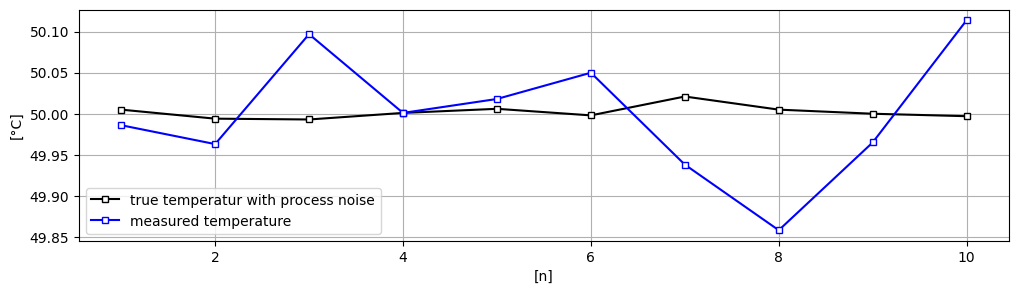

In [2]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,3))

ax1.plot(np.arange(len(x_pn)) +1, x_pn, color='k',  marker='s', markersize=4, markerfacecolor='w', label='true temperatur with process noise')
ax1.plot(np.arange(len(x_pn)) +1, r_n, color='b',  marker='s', markersize=4, markerfacecolor='w', label='measured temperature')
ax1.set_xlabel('[n]')
ax1.set_ylabel('[°C]')
ax1.set_title('')
ax1.legend()
ax1.grid(True)

Now we program the estimation procedure, print out the results for each iteration and display the estimated temperature ...

---

In [3]:
# initialisation

x_init = 60.0
p_init = 100**2

# a large initial variance is chosen to indicate that we do not have a trustworthy initial value

x_predictions = []
x_estimates = []
gains = []

for k, measurement in enumerate(r_n):
    if k==0:
        # prediction
        x_pre = x_init
        # predicted variance
        p_pre = p_init + var_q

    # iterations

    # Kalman gain
    K_gain = p_pre/(p_pre + var_r)
    # estimation of current state
    x_est = x_pre + K_gain * (measurement - x_pre)

    # put into results list
    x_estimates.append(x_est)
    x_predictions.append(x_pre)
    gains.append(K_gain)

    print(f"n: {k+1}; x_est[n] : {x_est:.3f}; x_pre[n] : {x_pre:.3f}; K_gain[n] : {K_gain:.6f}")
    
    # update variance and add process noise
    p_pre = (1 - K_gain) * p_pre + var_q
    # predict next temperature (temperature does not change)
    x_pre = x_est

# make numpy arrays
x_predictions = np.array(x_predictions)
x_estimates = np.array(x_estimates)
gains = np.array(gains)

n: 1; x_est[n] : 49.986; x_pre[n] : 60.000; K_gain[n] : 0.999999
n: 2; x_est[n] : 49.974; x_pre[n] : 49.986; K_gain[n] : 0.502487
n: 3; x_est[n] : 50.016; x_pre[n] : 49.974; K_gain[n] : 0.338837
n: 4; x_est[n] : 50.012; x_pre[n] : 50.016; K_gain[n] : 0.258621
n: 5; x_est[n] : 50.013; x_pre[n] : 50.012; K_gain[n] : 0.211742
n: 6; x_est[n] : 50.020; x_pre[n] : 50.013; K_gain[n] : 0.181497
n: 7; x_est[n] : 50.007; x_pre[n] : 50.020; K_gain[n] : 0.160720
n: 8; x_est[n] : 49.985; x_pre[n] : 50.007; K_gain[n] : 0.145824
n: 9; x_est[n] : 49.982; x_pre[n] : 49.985; K_gain[n] : 0.134817
n: 10; x_est[n] : 49.999; x_pre[n] : 49.982; K_gain[n] : 0.126498


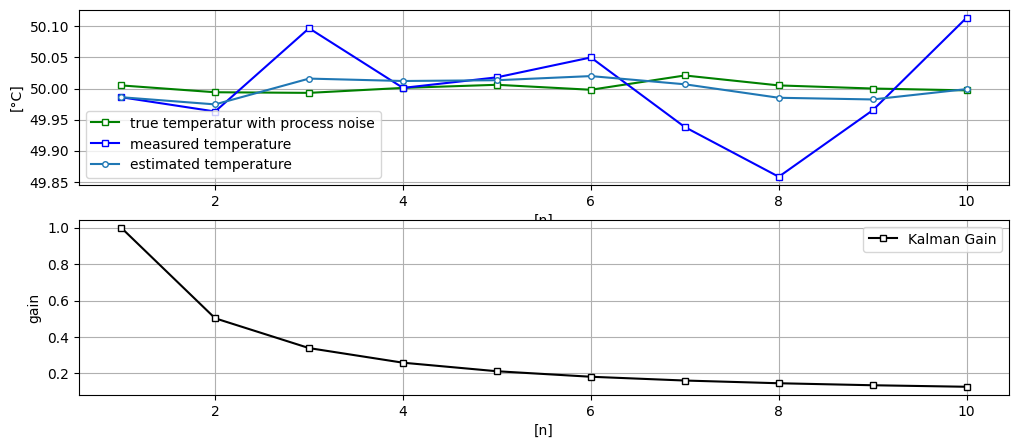

In [4]:
fig2, ax2 = plt.subplots(nrows=2, ncols=1, figsize=(12,5))

ax2[0].plot(np.arange(len(x_pn)) +1, x_pn, color='g',  marker='s', markersize=4, markerfacecolor='w', label='true temperatur with process noise')
ax2[0].plot(np.arange(len(x_pn)) +1, r_n, color='b',  marker='s', markersize=4, markerfacecolor='w', label='measured temperature')
ax2[0].plot(np.arange(len(x_pn)) +1, x_estimates, marker='o', markersize=4, markerfacecolor='w', label='estimated temperature')
ax2[0].set_xlabel('[n]')
ax2[0].set_ylabel('[°C]')
ax2[0].set_title('')
ax2[0].legend()
ax2[0].grid(True)

ax2[1].plot(np.arange(len(x_pn)) +1, gains, color='k',  marker='s', markersize=4, markerfacecolor='w', label='Kalman Gain')
ax2[1].set_xlabel('[n]')
ax2[1].set_ylabel('gain')
ax2[1].set_title('')
ax2[1].legend()
ax2[1].grid(True)

**Summary**

The monotonic convergence of the Kalman gain to fairly low values after 10 iterations indicates the validity of the model.

Numerical deviations from the example in the book are most likely caused by rounding errors.

---

## Example / Estimating the temperature of the liquid (with heating)

**Problem statement**

This time the temperature of a liquid in a tank is no longer constant. Instead we assume the liquid is heated with a rate of $0.1 °C$ per second.

Parameters are chosen similar to the first example (constant temperature).

**Assumptions**


| Parameter | Value | Description |
|-----------|-------|-------------|
| $T$       | 50 C° | true temperature |
| $q$       | $0.0001 \ C^2$ | process noise (very small -> indicating great confidence in the model) |
| $r_n$     | temperature measured at $n \cdot \Delta t$| temperature measurement |
| $\sigma_r$     |  0.1 °C | standard deviation of temperature measurement |
| $\Delta t$ | 5 s | time between measurements |

However we still assume a *constant dynamic* model (as in the previous case). So we a mismatch of the model with true system. The purpose 
of this example is to show the impact of this model mismatch.

With process noise sample values for the true temperature $x_n$ are provided in the book:

$x_n := \left[50.505, 50.994, 51.493, 52.001, 52.506, 52.998, 53.521, 54.005, 54.5, 54.997  \right] °C$

The measurements are:

$r_n := \left[50.486, 50.963, 51.597, 52.001, 52.518, 53.05, 53.438, 53.858, 54.465, 55.114  \right] °C$

On average we expect the temperature to increase by $0.5 \ °C$ every $5$ seconds.

**Initialisation**

Our initial belief of the temperature is :

$$
\hat{x}_{0,0} = 10 \ °C
$$

$$
p_{0,0} = 100^2
$$

In [5]:
# true temperature including process noise
x_pn2 = np.array([50.505, 50.994, 51.493, 52.001, 52.506, 52.998, 53.521, 54.005, 54.5, 54.997])
# measured temperature
r_n2 = np.array([50.486, 50.963, 51.597, 52.001, 52.518, 53.05, 53.438, 53.858, 54.465, 55.114])


dt2 = 5.0
sigma_r2 = 0.1
var_r2 = sigma_r**2
var_q2 = 0.0001

# initialisation temperature
x_init2 = 10.0
# a large initial variance is chosen to indicate that we do not have a trustworthy initial value of the initial temperature
p_init2 = 100**2

x_predictions2 = []
x_estimates2 = []
gains2 = []

for k, measurement in enumerate(r_n2):
    if k==0:
        # prediction
        x_pre = x_init2
        # predicted variance
        p_pre = p_init2 + var_q2

    # iterations

    # Kalman gain
    K_gain = p_pre/(p_pre + var_r2)
    # estimation of current state
    x_est = x_pre + K_gain * (measurement - x_pre)

    # put into results list
    x_estimates2.append(x_est)
    x_predictions2.append(x_pre)
    gains2.append(K_gain)

    print(f"n: {k+1}; x_est[n] : {x_est:.3f}; x_pre[n] : {x_pre:.3f}; K_gain[n] : {K_gain:.6f}")
    
    # update variance and add process noise
    p_pre = (1 - K_gain) * p_pre + var_q2
    # predict next temperature (temperature does not change)
    x_pre = x_est

# make numpy arrays
x_predictions2 = np.array(x_predictions2)
x_estimates2 = np.array(x_estimates2)
gains2 = np.array(gains2)

n: 1; x_est[n] : 50.486; x_pre[n] : 10.000; K_gain[n] : 0.999999
n: 2; x_est[n] : 50.726; x_pre[n] : 50.486; K_gain[n] : 0.502487
n: 3; x_est[n] : 51.021; x_pre[n] : 50.726; K_gain[n] : 0.338837
n: 4; x_est[n] : 51.274; x_pre[n] : 51.021; K_gain[n] : 0.258621
n: 5; x_est[n] : 51.538; x_pre[n] : 51.274; K_gain[n] : 0.211742
n: 6; x_est[n] : 51.812; x_pre[n] : 51.538; K_gain[n] : 0.181497
n: 7; x_est[n] : 52.073; x_pre[n] : 51.812; K_gain[n] : 0.160720
n: 8; x_est[n] : 52.334; x_pre[n] : 52.073; K_gain[n] : 0.145824
n: 9; x_est[n] : 52.621; x_pre[n] : 52.334; K_gain[n] : 0.134817
n: 10; x_est[n] : 52.936; x_pre[n] : 52.621; K_gain[n] : 0.126498


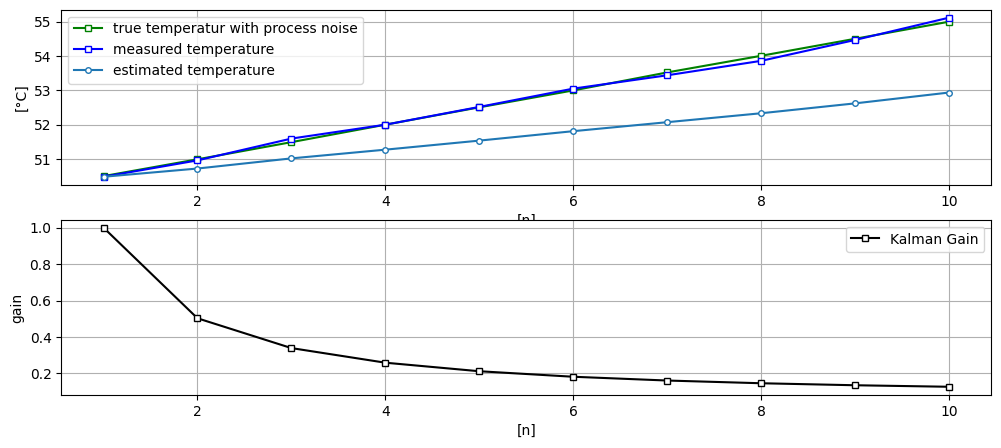

In [6]:
fig3, ax3 = plt.subplots(nrows=2, ncols=1, figsize=(12,5))

ax3[0].plot(np.arange(len(x_pn2)) +1, x_pn2, color='g',  marker='s', markersize=4, markerfacecolor='w', label='true temperatur with process noise')
ax3[0].plot(np.arange(len(x_pn2)) +1, r_n2, color='b',  marker='s', markersize=4, markerfacecolor='w', label='measured temperature')
ax3[0].plot(np.arange(len(x_pn2)) +1, x_estimates2, marker='o', markersize=4, markerfacecolor='w', label='estimated temperature')
ax3[0].set_xlabel('[n]')
ax3[0].set_ylabel('[°C]')
ax3[0].set_title('')
ax3[0].legend()
ax3[0].grid(True)

ax3[1].plot(np.arange(len(x_pn2)) +1, gains2, color='k',  marker='s', markersize=4, markerfacecolor='w', label='Kalman Gain')
ax3[1].set_xlabel('[n]')
ax3[1].set_ylabel('gain')
ax3[1].set_title('')
ax3[1].legend()
ax3[1].grid(True)

**Summary**

The model mismatch (constant temperature vs. linearly increasing temperature) leads to a *lag error*.


---

### Increase Process Noise while still assuming constant temperature model



In [7]:
dt3 = 5.0
sigma_r3 = 0.1
var_r3 = sigma_r**2
var_q3 = 0.15

# initialisation temperature
x_init3 = 10.0
# a large initial variance is chosen to indicate that we do not have a trustworthy initial value of the initial temperature
p_init3 = 100**2

x_predictions3 = []
x_estimates3 = []
gains3 = []

for k, measurement in enumerate(r_n2):
    if k==0:
        # prediction
        x_pre = x_init3
        # predicted variance
        p_pre = p_init3 + var_q3

    # iterations

    # Kalman gain
    K_gain = p_pre/(p_pre + var_r3)
    # estimation of current state
    x_est = x_pre + K_gain * (measurement - x_pre)

    # put into results list
    x_estimates3.append(x_est)
    x_predictions3.append(x_pre)
    gains3.append(K_gain)

    print(f"n: {k+1}; x_est[n] : {x_est:.3f}; x_pre[n] : {x_pre:.3f}; K_gain[n] : {K_gain:.6f}")
    
    # update variance and add process noise
    p_pre = (1 - K_gain) * p_pre + var_q3
    # predict next temperature (temperature does not change)
    x_pre = x_est

# make numpy arrays
x_predictions3 = np.array(x_predictions3)
x_estimates3 = np.array(x_estimates3)
gains3 = np.array(gains3)

n: 1; x_est[n] : 50.486; x_pre[n] : 10.000; K_gain[n] : 0.999999
n: 2; x_est[n] : 50.935; x_pre[n] : 50.486; K_gain[n] : 0.941176
n: 3; x_est[n] : 51.558; x_pre[n] : 50.935; K_gain[n] : 0.940972
n: 4; x_est[n] : 51.975; x_pre[n] : 51.558; K_gain[n] : 0.940972
n: 5; x_est[n] : 52.486; x_pre[n] : 51.975; K_gain[n] : 0.940972
n: 6; x_est[n] : 53.017; x_pre[n] : 52.486; K_gain[n] : 0.940972
n: 7; x_est[n] : 53.413; x_pre[n] : 53.017; K_gain[n] : 0.940972
n: 8; x_est[n] : 53.832; x_pre[n] : 53.413; K_gain[n] : 0.940972
n: 9; x_est[n] : 54.428; x_pre[n] : 53.832; K_gain[n] : 0.940972
n: 10; x_est[n] : 55.073; x_pre[n] : 54.428; K_gain[n] : 0.940972


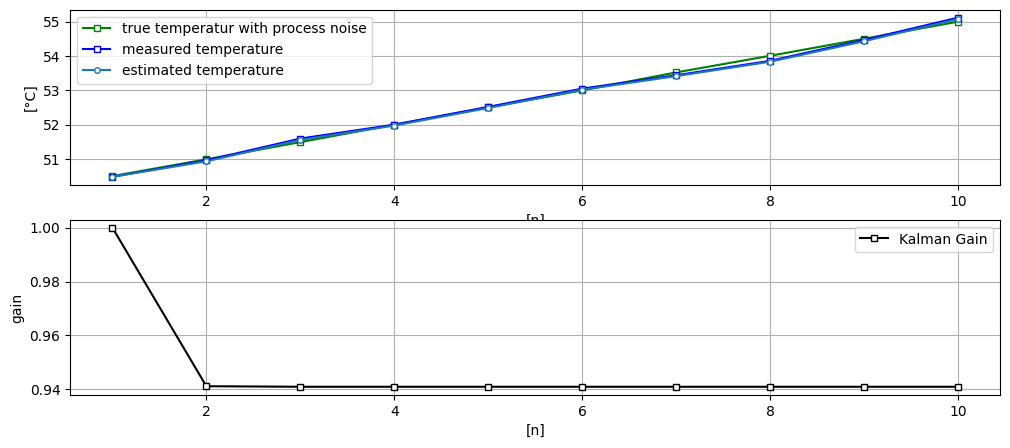

In [8]:
fig4, ax4 = plt.subplots(nrows=2, ncols=1, figsize=(12,5))

ax4[0].plot(np.arange(len(x_pn2)) +1, x_pn2, color='g',  marker='s', markersize=4, markerfacecolor='w', label='true temperatur with process noise')
ax4[0].plot(np.arange(len(x_pn2)) +1, r_n2, color='b',  marker='s', markersize=4, markerfacecolor='w', label='measured temperature')
ax4[0].plot(np.arange(len(x_pn2)) +1, x_estimates3, marker='o', markersize=4, markerfacecolor='w', label='estimated temperature')
ax4[0].set_xlabel('[n]')
ax4[0].set_ylabel('[°C]')
ax4[0].set_title('')
ax4[0].legend()
ax4[0].grid(True)

ax4[1].plot(np.arange(len(x_pn2)) +1, gains3, color='k',  marker='s', markersize=4, markerfacecolor='w', label='Kalman Gain')
ax4[1].set_xlabel('[n]')
ax4[1].set_ylabel('gain')
ax4[1].set_title('')
ax4[1].legend()
ax4[1].grid(True)

**Summary**

Increasing the process noise resulted in an excellent match of measured, estimated and true temperatures.

However the Kalman gain stays quite close to 1. This shows that the estimation process is dominated by the measurements. 

**Todo**

Build a **better model** which takes into account rate change of temperature

---